In [1]:
import numpy as np
from scipy.spatial import distance
import dlc_tda_ppross as dlcp
import embedding
import matplotlib.pyplot as plt
from numba import jit

import seaborn as sns

@jit(nopython=True)
def find_ind(inp, l):

    '''
    Finds index of a given element in an array
    ----
        inp: the vector to search in
        l: the target we want to find the index for
    ---
        j: is a float, for JIT maintenence
    '''
    
    
    j=0
    for i in inp:               #condition. l=inp[j]
        if i==l:                #if the condition is true report the counter
            return float(j)
        else:                   #if not cycle
            j+=1





@jit(nopython=True)
def euc_dist(p1, v2): #p1: point, v1:vector
    
    '''
        the euclidian distance between a point and individual elements of a vector, 
        Both should have the same dimentions
    ----
        p1:
        v2: 
    '''


    dist_pt=np.zeros(len(p1))                    #initialization
    dist_vct=np.zeros(len(v2))
    k=0


    for j in v2:
        for i in range(len(p1)):                  #calculate distance along each individual dimention (length of the point p)
            dist_pt[i]=(p1[i]-j[i])**2 
        dist_vct[k]=np.sqrt(np.sum(dist_pt))     #sum up the distances and take the square root
        k+=1

    return dist_vct



@jit(nopython=True)
def simp_nnb(inp,t_point):

    '''
    reports the indices and distances of the nearest neighb. of t_point (index of an element in inp)
    ---
        inp: manifold
        t_poin: int, the index of the time point for near neighb
    ---
        near_n_ind: indicies of the nearest neighbours
        dist: distances with the nearest neighbours
    '''

    dist1=euc_dist(inp[t_point], inp)       #get the distance vector between inp vector and inp[t_point] point
    dist2=np.sort(dist1)                    #sort the distance vector to get the neighbourhood


    near_n_ind=np.zeros_like(dist2[1:])
    k=0


    for dis in dist2[1:]:    #find the index of the sorted distances in the distance vector to get the indicies of the near neighb.
        near_n_ind[k]=find_ind(dist1, dis) 
        k+=1



    return   near_n_ind, dist2[1:] #dont report the distance with the point itself (0)




@jit(nopython=True)
def euc_dist1(p1,p2): #p1 and p2 are n-dimentiona points


    '''
        Same as the euclidian distance between point and vector but for two points
        python shnanigans
    ----
        p1, p2: two points in the same dimensions.

    '''


    dist_pt=np.zeros(len(p1))
    for i in range(len(p1)):
        dist_pt[i]=(p1[i]-p2[i])**2




    return np.sqrt(np.sum(dist_pt))



#scoring the predictions

def score(preds, actual):

    'This part of the code for scoring the predictions was taken directly from CCM package'


    """The coefficient R^2 is defined as (1 - u/v), where u is the regression
    sum of squares ((y_true - y_pred) ** 2).sum() and v is the residual
    sum of squares ((y_true - y_true.mean()) ** 2).sum(). Best possible
    score is 1.0, lower values are worse.
    Parameters
    ----------
    preds : 1d array
        Predicted values.
    actual : 1d array
        Actual values from the testing set.
    Returns
    -------
    cc : float
        Returns the coefficient of determiniation between preds and actual.
    """

    u = np.square(actual - preds ).sum()
    v = np.square(actual - actual.mean()).sum()
    r2 = 1 - u/v

    return r2



def simplex_pr(inp,dim, forecast_l,train_frac, trk_p):

    '''
    Forcasts the manifold
    -----
        inp: the manifold
        dim: number of the dimentions in the manifold
        forecast_l: number of time points to be forecasted
        train_frac: the fraction of time 
    -----
        scr: scores of the predicted vector, scr[i] corresponds to score of predicion [:i]
        prediction: the prediction manifold
    '''


    #### Data prep
    inp_t_p=int(inp.shape[0]*train_frac)
    track_p=inp_t_p-trk_p #this value is very important higher the number, higher the forcast 

    inp_t=inp[:inp_t_p]

    #calculate the weights
    ind_in ,dist=simp_nnb(inp_t,track_p) #0 to inp_t_p

    wi=np.zeros(dim+1)
    k=0
    for i in ind_in[:dim+1]:
        wi[k]=np.exp(-dist[i.astype(np.int32)-1]/dist[0])
        k+=1
    #s_wi=wi.sum()





    #make predictions 


    prediction=np.zeros((forecast_l,inp.shape[1]))

    m=0
    for i in range(forecast_l):

        
        y_hat=np.array([0.0]*inp.shape[1])
        s_wi=0
        
        for j in range(dim+1):
            try:
                y_hat+=wi[j]*inp_t[int(ind_in[j])+i]
                s_wi+=wi[j]
            except:
                pass
        if s_wi>0:
            prediction[m]=y_hat/s_wi
        m+=1



    #score predictions 
    scr=np.zeros(forecast_l-1)
    m=0
    for p in range(1,prediction.shape[0]):
        scr[m]=score(inp[track_p:track_p+p], prediction[:p])
        m=m+1



    return scr,prediction



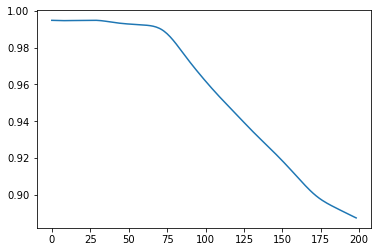

In [30]:
case='/home/morteza/dlc_projects/Analysis/Currencodes/TDA/pilot_data/SKF19.csv'



m_head_x=(dlcp.retrivedata(case,'headR')+dlcp.retrivedata(case, 'headL'))/2        #get bodypart signals
m_head_y=(dlcp.retrivedata(case, 'headR.1')+dlcp.retrivedata(case, 'headL.1'))/2
tail_x=dlcp.retrivedata(case, 'tail')
tail_y=dlcp.retrivedata(case, 'tail.1')

ang_bod=np.array(dlcp.angs(tail_x, tail_y, m_head_x, m_head_y))
d_body=dlcp.smooth_diff(ang_bod)


dim=14

embeded=embedding.l_embed(d_body,100,1)
manif=embedding.svd_lags(embeded, dim)



trin_frac=0.93
frecast_l=200

scr,prediction=simplex_pr(manif,dim, frecast_l,trin_frac,30)

plt.plot(scr)

In [31]:
inp=manif
inp_t_p=int(inp.shape[0]*trin_frac)-31


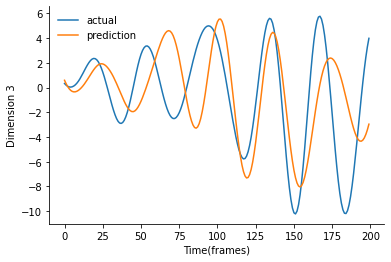

In [32]:

inspect_dim=6
plt.plot(manif[inp_t_p:inp_t_p+frecast_l,inspect_dim], label='actual')
plt.plot(prediction[:frecast_l,inspect_dim], label='prediction')

plt.legend(frameon=False)
plt.xlabel('Time(frames)')
plt.ylabel('Dimension 3')
sns.despine()


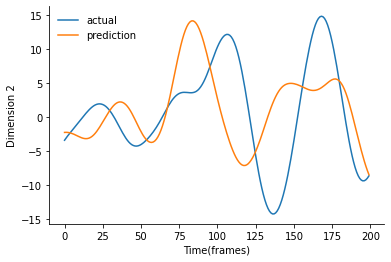

In [33]:
inspect_dim=3
plt.plot(manif[inp_t_p:inp_t_p+frecast_l,inspect_dim], label='actual')
plt.plot(prediction[:frecast_l,inspect_dim], label='prediction')

plt.legend(frameon=False)
plt.xlabel('Time(frames)')
plt.ylabel('Dimension 2')
sns.despine()

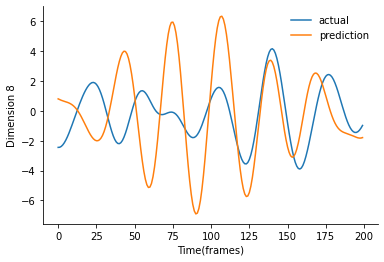

In [6]:
inspect_dim=6
plt.plot(manif[inp_t_p:inp_t_p+frecast_l,inspect_dim], label='actual')
plt.plot(prediction[:frecast_l,inspect_dim], label='prediction')

plt.legend(frameon=False)
plt.xlabel('Time(frames)')
plt.ylabel('Dimension 8')
sns.despine()

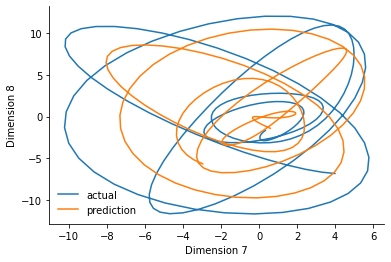

In [35]:
inspect_dim=6
plt.plot(manif[inp_t_p:inp_t_p+frecast_l,inspect_dim],manif[inp_t_p:inp_t_p+frecast_l,inspect_dim-1], label='actual')
plt.plot(prediction[:frecast_l,inspect_dim],prediction[:frecast_l,inspect_dim-1], label='prediction')

plt.legend(frameon=False)
plt.xlabel('Dimension 7')
plt.ylabel('Dimension 8')
sns.despine()

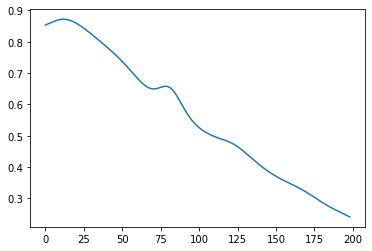

In [7]:
case='/home/morteza/dlc_projects/Analysis/Currencodes/TDA/pilot_data/LES1.csv'



m_head_x=(dlcp.retrivedata(case,'headR')+dlcp.retrivedata(case, 'headL'))/2        #get bodypart signals
m_head_y=(dlcp.retrivedata(case, 'headR.1')+dlcp.retrivedata(case, 'headL.1'))/2
tail_x=dlcp.retrivedata(case, 'tail')
tail_y=dlcp.retrivedata(case, 'tail.1')

ang_bod=np.array(dlcp.angs(tail_x, tail_y, m_head_x, m_head_y))
d_body=dlcp.smooth_diff(ang_bod)


dim=11

embeded=embedding.l_embed(d_body,100,1)
manif=embedding.svd_lags(embeded, dim)



trin_frac=0.82
frecast_l=200

scr,prediction=simplex_pr(manif,dim, frecast_l,trin_frac,10)

plt.plot(scr)

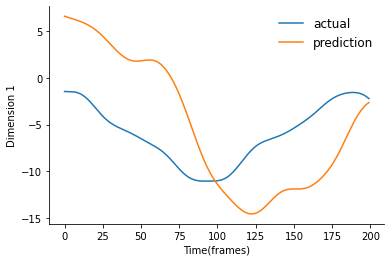

In [8]:
inspect_dim=0
plt.plot(manif[inp_t_p:inp_t_p+frecast_l,inspect_dim], label='actual')
plt.plot(prediction[:frecast_l,inspect_dim], label='prediction')
plt.legend(frameon=False, fontsize='large')
plt.xlabel('Time(frames)')
plt.ylabel('Dimension 1')
sns.despine()

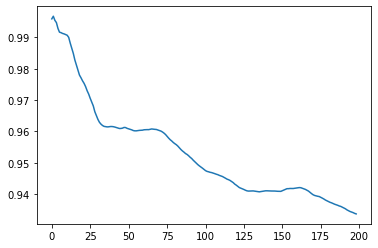

In [9]:
case='/home/morteza/dlc_projects/Analysis/Currencodes/TDA/pilot_data/SKF19.csv'



m_head_x=(dlcp.retrivedata(case,'headR')+dlcp.retrivedata(case, 'headL'))/2        #get bodypart signals
m_head_y=(dlcp.retrivedata(case, 'headR.1')+dlcp.retrivedata(case, 'headL.1'))/2
tail_x=dlcp.retrivedata(case, 'tail')
tail_y=dlcp.retrivedata(case, 'tail.1')

ang_bod=np.array(dlcp.angs(tail_x, tail_y, m_head_x, m_head_y))
d_body=dlcp.smooth_diff(ang_bod)
np.random.shuffle(d_body)

dim=11

embeded=embedding.l_embed(d_body,100,1)
manif=embedding.svd_lags(embeded, dim)



trin_frac=0.82
frecast_l=200

scr,prediction=simplex_pr(manif,dim, frecast_l,trin_frac,10)

plt.plot(scr)

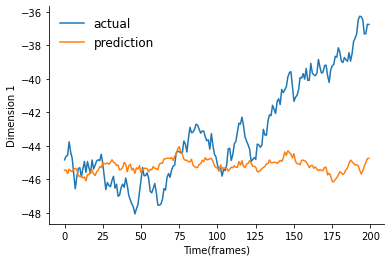

In [10]:
inspect_dim=0
plt.plot(manif[inp_t_p:inp_t_p+frecast_l,inspect_dim], label='actual')
plt.plot(prediction[:frecast_l,inspect_dim], label='prediction')
plt.legend(frameon=False, fontsize='large')
plt.xlabel('Time(frames)')
plt.ylabel('Dimension 1')
sns.despine()

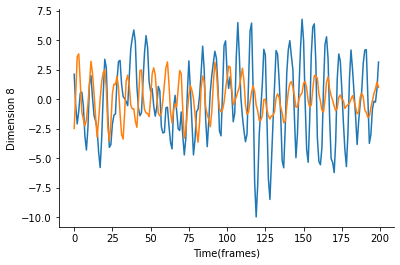

In [11]:
inspect_dim=7
plt.plot(manif[inp_t_p:inp_t_p+frecast_l,inspect_dim], label='actual')
plt.plot(prediction[:frecast_l,inspect_dim], label='prediction')

plt.xlabel('Time(frames)')
plt.ylabel('Dimension 8')
sns.despine()

The Arvind Controls

In [ ]:
case='/home/morteza/dlc_projects/Analysis/Currencodes/TDA/pilot_data/SKF19.csv'



m_head_x=(dlcp.retrivedata(case,'headR')+dlcp.retrivedata(case, 'headL'))/2        #get bodypart signals
m_head_y=(dlcp.retrivedata(case, 'headR.1')+dlcp.retrivedata(case, 'headL.1'))/2
tail_x=dlcp.retrivedata(case, 'tail')
tail_y=dlcp.retrivedata(case, 'tail.1')

ang_bod=np.array(dlcp.angs(tail_x, tail_y, m_head_x, m_head_y))
d_body=dlcp.smooth_diff(ang_bod)


dim=14

embeded=embedding.l_embed(d_body,100,1)


manif=embedding.svd_lags(embeded, dim)



trin_frac=0.93
frecast_l=200

scr,prediction=simplex_pr(manif,dim, frecast_l,trin_frac,30)

plt.plot(scr)


inspect_dim=6
plt.plot(manif[inp_t_p:inp_t_p+frecast_l,inspect_dim], label='actual')
plt.plot(prediction[:frecast_l,inspect_dim], label='prediction')

plt.legend(frameon=False)
plt.xlabel('Time(frames)')
plt.ylabel('Dimension 3')
sns.despine()
